In [1]:
from multiprocessing import Pool
from tqdm import tqdm
import random

from chess import Color, Piece, BoardPiece, Board, Move, Position
from rl import *
from chessrl import *

WHITE_PAWN_POS = Position(3,3)
WHITE_ROOK_POS = Position(3,1)
BLACK_PAWN_POS = Position(1,3)
BLACK_KING_POS = Position(0,3)

board = Board(4)
whitePawn = BoardPiece(Piece.Pawn, Color.White, WHITE_PAWN_POS)
whiteRook = BoardPiece(Piece.Rook, Color.White, WHITE_ROOK_POS)
blackPawn = BoardPiece(Piece.Pawn, Color.Black, BLACK_PAWN_POS)
blackKing = BoardPiece(Piece.King, Color.Black, BLACK_KING_POS)
board.addPiece(whitePawn)
board.addPiece(whiteRook)
board.addPiece(blackPawn)
board.addPiece(blackKing)
print(board)

def onStepEnd(env):
    """ Black plays a random (valid) move """
    if not env.isEndState():
        actions = env.getState().getAllPossibleActionsFor(Color.Black)
        if actions:
            env.execute(random.choice(actions))

qLearning = QLearning()
NUM_TRAIN_EPISODES = 50
NUM_TEST_EPISODES = 100
NUM_BATCHES = 100
MAX_STEPS = 20
TEST_EXPLOIT_RATE = 0.75
MAX_PROCESSES = 8

def trainExploitRate(batchNumber):
    return 0.5 + (batchNumber / NUM_BATCHES)/2

def trainEpisode(batchNumber):
    env = Environment(BoardState(board.clone()))
    episode = Episode(env, qLearning, trainExploitRate(batchNumber))
    return episode.step(MAX_STEPS, onStepEnd=onStepEnd)

def testEpisode():
    env = Environment(BoardState(board.clone()))
    episode = Episode(env, qLearning, TEST_EXPLOIT_RATE)
    steps = episode.step(MAX_STEPS, onStepEnd=onStepEnd)
    return (env.getState().isWinState(), steps, qLearning.getStateAction(env.getState()).getMaxReward())
    
rWins = []
eRates = []
nStates = []
nSteps = []
stateMaxRewards = []

USE_MULTITHREAD = True

for b in tqdm(range(NUM_BATCHES)):

    if USE_MULTITHREAD:
        with Pool(processes=MAX_PROCESSES) as pool:
            pool.map(trainEpisode, range(NUM_TRAIN_EPISODES))
    else:
        for i in range(NUM_TRAIN_EPISODES):
            trainEpisode(i)

    wins = 0
    totalSteps = 0
    stateMaxReward = 0
    for i in range(NUM_TEST_EPISODES):
        (isWin, steps, maxReward) = testEpisode()
        stateMaxReward = stateMaxReward + maxReward
        totalSteps = totalSteps + steps
        if isWin:
            wins = wins + 1

    totalStates = len(qLearning.sas)
    stateMaxRewards.append(stateMaxReward / NUM_TEST_EPISODES)
    rWins.append(wins)
    eRates.append(trainExploitRate(b))
    nStates.append(totalStates)
    nSteps.append(totalSteps / NUM_TEST_EPISODES)


+----+
|···♚|
|···♟|
|····|
|·♖·♙|
+----+


100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


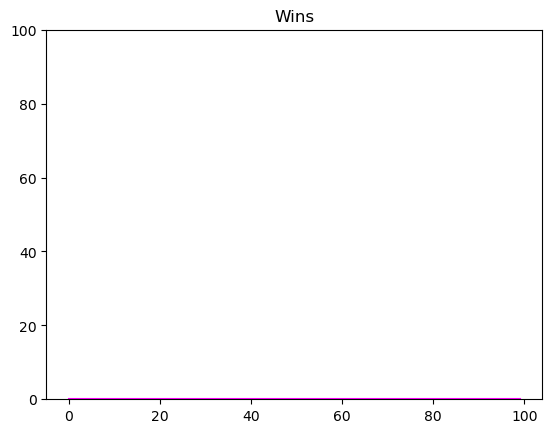

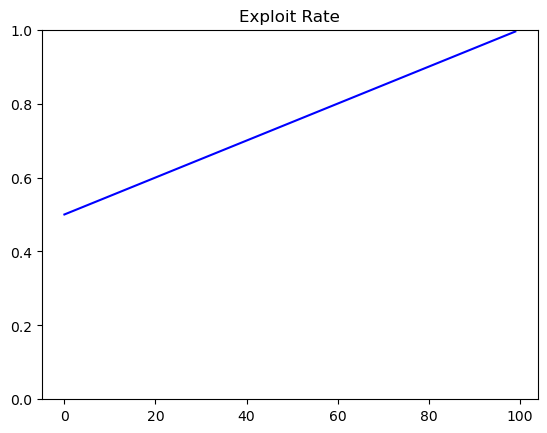

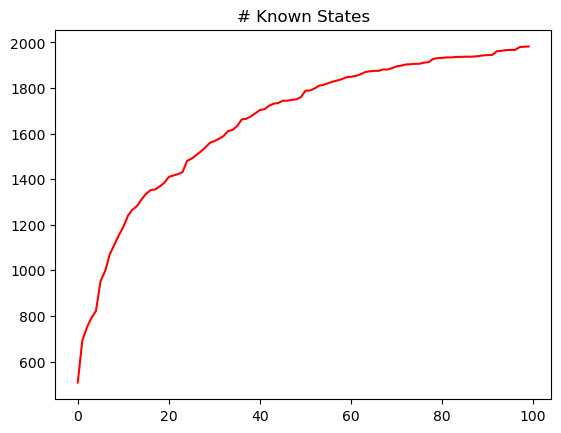

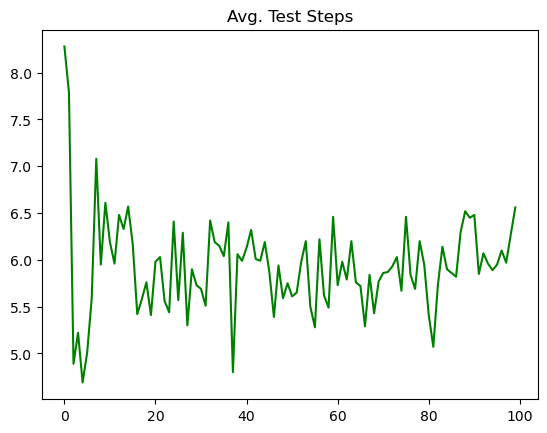

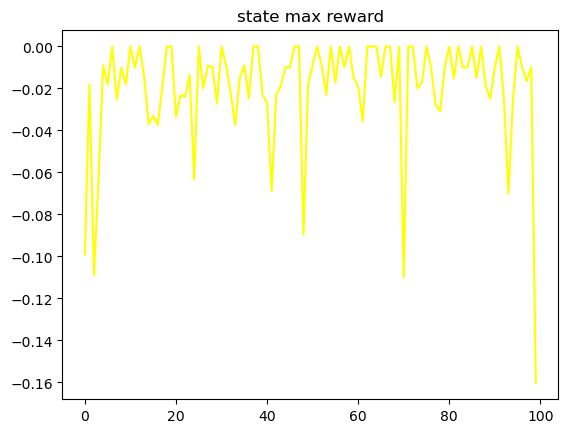

In [2]:
import matplotlib.pyplot as plt

x = range(NUM_BATCHES)
plt.plot(x, rWins, label='Wins', color='magenta')
plt.title("Wins")
plt.ylim(0, NUM_TEST_EPISODES)
plt.show()

plt.plot(x, eRates, label="Exploit Rate", color='blue')
plt.title("Exploit Rate")
plt.ylim(0, 1)
plt.show()

plt.plot(x, nStates, label="Known States", color='red')
plt.title("# Known States")
plt.show()

plt.plot(x, nSteps, label="Avg. Test Steps", color='green')
plt.title("Avg. Test Steps")
plt.show()

plt.plot(x, stateMaxRewards, label="state max reward", color='yellow')
plt.title("state max reward")
plt.show()